In [1]:
import pandas as pd
import pickle
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.layers import LeakyReLU
#!pip install np_utils
from keras import utils

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# set random seeds

# removed the import statement for set_session from tensorflow.compat.v1.keras.backend
np.random.seed(1)
tf.random.set_seed(2)

# limit gpu usage for keras with tensorflow 1
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# set_session(tf.compat.v1.Session(config=config))

# If you need to use set_session, try this instead:
# from tensorflow.python.keras.backend import set_session

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
if not os.path.isfile('/content/drive/MyDrive/LOBCNN/data/data.zip'):
    !wget https://raw.githubusercontent.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books/master/data/data.zip
    !unzip -n data.zip
    print('data downloaded.')
else:
    print('data already existed.')

data already existed.


In [4]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T - 1:N]
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(dataX.shape + (1,)), dataY

def prepare_x_y(data, k, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    y = y[:,k] - 1
    y = utils.to_categorical(y, 3)
    return x, y

In [5]:
dec_data = np.loadtxt('/content/drive/MyDrive/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books-master/data/data.zip (Unzipped Files)/Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('/content/drive/MyDrive/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books-master/data/data.zip (Unzipped Files)/Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('/content/drive/MyDrive/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books-master/data/data.zip (Unzipped Files)/Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('/content/drive/MyDrive/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books-master/data/data.zip (Unzipped Files)/Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

k = 4 # which prediction horizon
T = 100 # the length of a single input
n_hiddens = 64
checkpoint_filepath = './model_tensorflow1_weights'

trainX_CNN, trainY_CNN = prepare_x_y(dec_train, k, T)
valX_CNN, valY_CNN = prepare_x_y(dec_val, k, T)
testX_CNN, testY_CNN = prepare_x_y(dec_test, k, T)

print(trainX_CNN.shape, trainY_CNN.shape)
print(valX_CNN.shape, valY_CNN.shape)
print(testX_CNN.shape, testY_CNN.shape)

(203701, 100, 40, 1) (203701, 3)
(50851, 100, 40, 1) (50851, 3)
(139488, 100, 40, 1) (139488, 3)


In [6]:
def create_cnn_model(input_shape):
    input_layer = Input(shape=input_shape)
    conv1 = Conv2D(64, kernel_size=(4, 40), activation='relu')(input_layer)
    conv2 = Conv2D(32, kernel_size=(4, 1), activation='relu')(conv1)
    maxpool2 = MaxPooling2D(pool_size=(2, 1))(conv2)
    conv3 = Conv2D(16, kernel_size=(3, 1), activation='relu')(maxpool2)
    conv4 = Conv2D(16, kernel_size=(3, 1), activation='relu')(conv3)
    maxpool4 = MaxPooling2D(pool_size=(2, 1))(conv4)
    flatten = Flatten()(maxpool4)
    dense1 = Dense(16, activation='relu')(flatten)
    output_layer = Dense(3, activation='softmax')(dense1)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

input_shape = (100, 40, 1)

cnn_model = create_cnn_model(input_shape)

cnn_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 40, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 97, 1, 64)           │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 94, 1, 32)           │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 1, 16)           │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 43, 1, 16)           │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 21, 1, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 336)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           5,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,307 (102.76 KB)

 Trainable params: 26,307 (102.76 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
%%time

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./cnn1.weights.h5', # Added '.weights.h5' to the filepath
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

cnn_model.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN),
            epochs=10, batch_size=128, verbose=1, callbacks=[model_checkpoint_callback])

Epoch 1/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.4211 - loss: 1.0335 - val_accuracy: 0.4021 - val_loss: 1.0817
Epoch 2/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5070 - loss: 0.9793 - val_accuracy: 0.4473 - val_loss: 1.0649
Epoch 3/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5447 - loss: 0.9259 - val_accuracy: 0.4704 - val_loss: 1.0227
Epoch 4/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5709 - loss: 0.8876 - val_accuracy: 0.5047 - val_loss: 0.9851
Epoch 5/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5856 - loss: 0.8626 - val_accuracy: 0.4717 - val_loss: 1.0120
Epoch 6/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5952 - loss: 0.8474 - val_accuracy: 0.5111 - val_loss: 0.9720
Epoch 7/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6110 - loss: 0.8267 - val_accuracy: 0.5121 - val_loss: 0.9681
Epoch 8/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6201 - loss: 0.8130 -

In [8]:
print(accuracy_score(np.argmax(testY_CNN, axis=1), np.argmax(cnn_model.predict(testX_CNN), axis=1)))

4359/4359 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
0.579203945859142


4359/4359 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


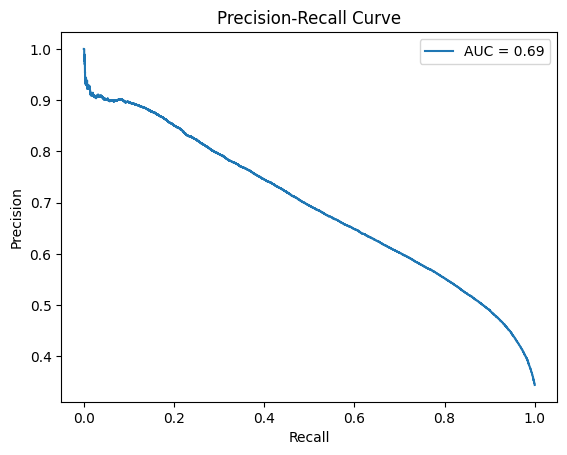

In [9]:
from sklearn.metrics import precision_recall_curve, auc

# Get predicted probabilities for the positive class
y_pred_proba = cnn_model.predict(testX_CNN)[:, 1]

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(testY_CNN[:, 1], y_pred_proba)

# Calculate area under the curve
auc_score = auc(recall, precision)

# Plot the precision-recall curve
plt.plot(recall, precision, label=f'AUC = {auc_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(np.argmax(testY_CNN, axis=1), np.argmax(cnn_model.predict(testX_CNN), axis=1)))

4359/4359 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
              precision    recall  f1-score   support

           0       0.56      0.57      0.57     47915
           1       0.63      0.63      0.63     48050
           2       0.54      0.53      0.54     43523

    accuracy                           0.58    139488
   macro avg       0.58      0.58      0.58    139488
weighted avg       0.58      0.58      0.58    139488



In [11]:
print(accuracy_score(np.argmax(trainY_CNN, axis=1), np.argmax(cnn_model.predict(trainX_CNN), axis=1)))

6366/6366 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
0.6408559604518387


6366/6366 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


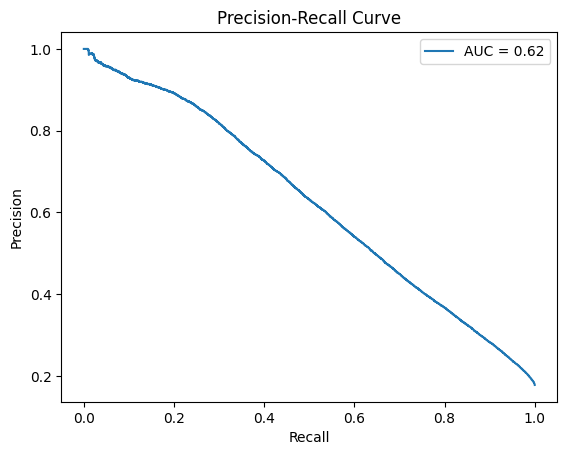

In [12]:
from sklearn.metrics import precision_recall_curve, auc

# Get predicted probabilities for the positive class
y_pred_proba = cnn_model.predict(trainX_CNN)[:, 1]

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(trainY_CNN[:, 1], y_pred_proba)

# Calculate area under the curve
auc_score = auc(recall, precision)

# Plot the precision-recall curve
plt.plot(recall, precision, label=f'AUC = {auc_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(np.argmax(trainY_CNN, axis=1), np.argmax(cnn_model.predict(trainX_CNN), axis=1)))

6366/6366 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
              precision    recall  f1-score   support

           0       0.65      0.68      0.66     84426
           1       0.61      0.52      0.56     36210
           2       0.65      0.66      0.65     83065

    accuracy                           0.64    203701
   macro avg       0.63      0.62      0.62    203701
weighted avg       0.64      0.64      0.64    203701



In [14]:
## MIDDLE PRICE, DENORMALISED, SMOOTHENING,   TEST, LABELS BASED ON DEEPLOB  ##
import numpy as np
import pandas as pd

print("Getting predictions...")
train_predictions = cnn_model.predict(testX_CNN)

# First define our strategy function
def implement_fi2010_strategy(predictions, dec_data, budget=100, prob_threshold=0.5, k=4, alpha=0.001):
    """
    Implements trading strategy using the FI-2010 paper's methodology

    Args:
        predictions: numpy array of model predictions (n_samples, 3)
        dec_data: numpy array of decoded price data
        budget: amount to invest per trade
        prob_threshold: probability threshold for trading
        k: prediction horizon (number of steps to look ahead)
        alpha: threshold for determining price movement direction
    """
    # Get normalized ask and bid prices
    ask_prices = dec_data[0, :]
    bid_prices = dec_data[2, :]
    mid_prices = (ask_prices + bid_prices) / 2

    min_length = min(len(predictions), len(mid_prices) - k)
    predictions = predictions[:min_length]

    trades_info = []

    for i in range(k, min_length):
        # Calculate m+ (future average) according to paper
        m_plus = np.mean(mid_prices[i+1:i+k+1])

        # Calculate actual price movement using paper's method
        lt = (m_plus - mid_prices[i]) / mid_prices[i]

        pred_class = np.argmax([predictions[i, 0], predictions[i, 1], predictions[i, 2]])
        max_prob = np.max([predictions[i, 0], predictions[i, 1], predictions[i, 2]])

        if max_prob > prob_threshold and pred_class != 1:  # not stable
            # Determine actual direction using same threshold as training
            actual_direction = 1 if lt > alpha else (-1 if lt < -alpha else 0)

            # Long trade (UP prediction)
            if pred_class == 2:
                shares = budget / mid_prices[i]
                cost = shares * mid_prices[i]
                proceeds = shares * m_plus
                profit = proceeds - cost

                trades_info.append({
                    'movement': 'up',
                    'entry_price': mid_prices[i],
                    'exit_price': m_plus,
                    'shares': shares,
                    'price_change': m_plus - mid_prices[i],
                    'price_change_pct': lt,
                    'cost': cost,
                    'proceeds': proceeds,
                    'profit': profit,
                    'prob': predictions[i, 2],
                    'correct': actual_direction == 1,
                    'index': i
                })

            # Short trade (DOWN prediction)
            elif pred_class == 0:
                shares = budget / mid_prices[i]
                proceeds = shares * mid_prices[i]
                cost = shares * m_plus
                profit = proceeds - cost

                trades_info.append({
                    'movement': 'down',
                    'entry_price': mid_prices[i],
                    'exit_price': m_plus,
                    'shares': shares,
                    'price_change': m_plus - mid_prices[i],
                    'price_change_pct': lt,
                    'cost': cost,
                    'proceeds': proceeds,
                    'profit': profit,
                    'prob': predictions[i, 0],
                    'correct': actual_direction == -1,
                    'index': i
                })

    if trades_info:
        trades_df = pd.DataFrame(trades_info)

        # Print performance metrics
        print("\nTrading Performance:")
        print(f"Total trades: {len(trades_df)}")
        print(f"Win rate: {(trades_df['correct'].mean() * 100):.2f}%")
        print(f"Total profit: ${trades_df['profit'].sum():.2f}")
        print(f"Average profit per trade: ${trades_df['profit'].mean():.4f}")

        print("\nDirection Analysis:")
        for direction in ['up', 'down']:
            mask = trades_df['movement'] == direction
            if mask.any():
                direction_df = trades_df[mask]
                print(f"\n{direction.upper()} trades:")
                print(f"Count: {len(direction_df)}")
                print(f"Win rate: {(direction_df['correct'].mean() * 100):.2f}%")
                print(f"Total profit: ${direction_df['profit'].sum():.2f}")
                print(f"Average profit: ${direction_df['profit'].mean():.4f}")

        return {
            'threshold': prob_threshold,
            'total_profit': trades_df['profit'].sum(),
            'num_trades': len(trades_df),
            'win_rate': trades_df['correct'].mean() * 100,
            'avg_profit': trades_df['profit'].mean(),
            'long_trades': len(trades_df[trades_df['movement'] == 'up']),
            'short_trades': len(trades_df[trades_df['movement'] == 'down'])
        }
    return None

# Test different probability thresholds
thresholds = [0.8, 0.85, 0.9, 0.95, 0.99]
results = []

print("Testing strategy with different thresholds...")
for threshold in thresholds:
    print(f"\nTesting threshold: {threshold}")
    result = implement_fi2010_strategy(
        predictions=train_predictions,
        dec_data=dec_test,
        prob_threshold=threshold,
        k=4,
        alpha=0.001
    )
    if result:
        results.append(result)

# Create summary table
if results:
    results_df = pd.DataFrame(results)
    print("\nSummary of results for different probability thresholds:")
    pd.set_option('display.float_format', lambda x: '{:.6f}'.format(x))
    print(results_df)

Getting predictions...
4359/4359 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Testing strategy with different thresholds...

Testing threshold: 0.8

Trading Performance:
Total trades: 15000
Win rate: 0.46%
Total profit: $87.88
Average profit per trade: $0.0059

Direction Analysis:

UP trades:
Count: 7809
Win rate: 0.47%
Total profit: $-106.50
Average profit: $-0.0136

DOWN trades:
Count: 7191
Win rate: 0.45%
Total profit: $194.38
Average profit: $0.0270

Testing threshold: 0.85

Trading Performance:
Total trades: 11453
Win rate: 0.49%
Total profit: $63.26
Average profit per trade: $0.0055

Direction Analysis:

UP trades:
Count: 6017
Win rate: 0.55%
Total profit: $-105.53
Average profit: $-0.0175

DOWN trades:
Count: 5436
Win rate: 0.42%
Total profit: $168.79
Average profit: $0.0311

Testing threshold: 0.9

Trading Performance:
Total trades: 7918
Win rate: 0.51%
Total profit: $81.45
Average profit per trade: $0.0103

Direction Analysis:

UP trades:
Count: 4134
Win rate: 0.60%
Total profit: $-69.91


In [15]:
## MIDDLE PRICE, DENORMALISED, SMOOTHENING, TRAIN, LABELS BASED ON DEEPLOB  ##
import numpy as np
import pandas as pd

print("Getting predictions...")
train_predictions = cnn_model.predict(trainX_CNN)

# First define our strategy function
def implement_fi2010_strategy(predictions, dec_data, budget=100, prob_threshold=0.5, k=4, alpha=0.001):
    """
    Implements trading strategy using the FI-2010 paper's methodology

    Args:
        predictions: numpy array of model predictions (n_samples, 3)
        dec_data: numpy array of decoded price data
        budget: amount to invest per trade
        prob_threshold: probability threshold for trading
        k: prediction horizon (number of steps to look ahead)
        alpha: threshold for determining price movement direction
    """
    # Get normalized ask and bid prices
    ask_prices = dec_data[0, :]
    bid_prices = dec_data[2, :]
    mid_prices = (ask_prices + bid_prices) / 2

    min_length = min(len(predictions), len(mid_prices) - k)
    predictions = predictions[:min_length]

    trades_info = []

    for i in range(k, min_length):
        # Calculate m+ (future average) according to paper
        m_plus = np.mean(mid_prices[i+1:i+k+1])

        # Calculate actual price movement using paper's method
        lt = (m_plus - mid_prices[i]) / mid_prices[i]

        pred_class = np.argmax([predictions[i, 0], predictions[i, 1], predictions[i, 2]])
        max_prob = np.max([predictions[i, 0], predictions[i, 1], predictions[i, 2]])

        if max_prob > prob_threshold and pred_class != 1:  # not stable
            # Determine actual direction using same threshold as training
            actual_direction = 1 if lt > alpha else (-1 if lt < -alpha else 0)

            # Long trade (UP prediction)
            if pred_class == 2:
                shares = budget / mid_prices[i]
                cost = shares * mid_prices[i]
                proceeds = shares * m_plus
                profit = proceeds - cost

                trades_info.append({
                    'movement': 'up',
                    'entry_price': mid_prices[i],
                    'exit_price': m_plus,
                    'shares': shares,
                    'price_change': m_plus - mid_prices[i],
                    'price_change_pct': lt,
                    'cost': cost,
                    'proceeds': proceeds,
                    'profit': profit,
                    'prob': predictions[i, 2],
                    'correct': actual_direction == 1,
                    'index': i
                })

            # Short trade (DOWN prediction)
            elif pred_class == 0:
                shares = budget / mid_prices[i]
                proceeds = shares * mid_prices[i]
                cost = shares * m_plus
                profit = proceeds - cost

                trades_info.append({
                    'movement': 'down',
                    'entry_price': mid_prices[i],
                    'exit_price': m_plus,
                    'shares': shares,
                    'price_change': m_plus - mid_prices[i],
                    'price_change_pct': lt,
                    'cost': cost,
                    'proceeds': proceeds,
                    'profit': profit,
                    'prob': predictions[i, 0],
                    'correct': actual_direction == -1,
                    'index': i
                })

    if trades_info:
        trades_df = pd.DataFrame(trades_info)

        # Print performance metrics
        print("\nTrading Performance:")
        print(f"Total trades: {len(trades_df)}")
        print(f"Win rate: {(trades_df['correct'].mean() * 100):.2f}%")
        print(f"Total profit: ${trades_df['profit'].sum():.2f}")
        print(f"Average profit per trade: ${trades_df['profit'].mean():.4f}")

        print("\nDirection Analysis:")
        for direction in ['up', 'down']:
            mask = trades_df['movement'] == direction
            if mask.any():
                direction_df = trades_df[mask]
                print(f"\n{direction.upper()} trades:")
                print(f"Count: {len(direction_df)}")
                print(f"Win rate: {(direction_df['correct'].mean() * 100):.2f}%")
                print(f"Total profit: ${direction_df['profit'].sum():.2f}")
                print(f"Average profit: ${direction_df['profit'].mean():.4f}")

        return {
            'threshold': prob_threshold,
            'total_profit': trades_df['profit'].sum(),
            'num_trades': len(trades_df),
            'win_rate': trades_df['correct'].mean() * 100,
            'avg_profit': trades_df['profit'].mean(),
            'long_trades': len(trades_df[trades_df['movement'] == 'up']),
            'short_trades': len(trades_df[trades_df['movement'] == 'down'])
        }
    return None

# Test different probability thresholds
thresholds = [0.8, 0.85, 0.9, 0.95, 0.99]
results = []

print("Testing strategy with different thresholds...")
for threshold in thresholds:
    print(f"\nTesting threshold: {threshold}")
    result = implement_fi2010_strategy(
        predictions=train_predictions,
        dec_data=dec_train,
        prob_threshold=threshold,
        k=4,
        alpha=0.001
    )
    if result:
        results.append(result)

# Create summary table
if results:
    results_df = pd.DataFrame(results)
    print("\nSummary of results for different probability thresholds:")
    pd.set_option('display.float_format', lambda x: '{:.6f}'.format(x))
    print(results_df)

Getting predictions...
6366/6366 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Testing strategy with different thresholds...

Testing threshold: 0.8

Trading Performance:
Total trades: 37878
Win rate: 0.67%
Total profit: $28.00
Average profit per trade: $0.0007

Direction Analysis:

UP trades:
Count: 18762
Win rate: 0.67%
Total profit: $7.44
Average profit: $0.0004

DOWN trades:
Count: 19116
Win rate: 0.67%
Total profit: $20.56
Average profit: $0.0011

Testing threshold: 0.85

Trading Performance:
Total trades: 29367
Win rate: 0.67%
Total profit: $21.17
Average profit per trade: $0.0007

Direction Analysis:

UP trades:
Count: 14739
Win rate: 0.69%
Total profit: $5.14
Average profit: $0.0003

DOWN trades:
Count: 14628
Win rate: 0.65%
Total profit: $16.03
Average profit: $0.0011

Testing threshold: 0.9

Trading Performance:
Total trades: 20728
Win rate: 0.69%
Total profit: $12.98
Average profit per trade: $0.0006

Direction Analysis:

UP trades:
Count: 10500
Win rate: 0.69%
Total profit: $1.13
Averag

In [16]:
def calculate_perturbation_volume(original, perturbed):
    original_flat = original.reshape(original.shape[0], -1)
    perturbed_flat = perturbed.reshape(perturbed.shape[0], -1)
    perturbation = np.linalg.norm(original_flat - perturbed_flat, ord=2, axis=1)
    avg_perturbation = np.mean(perturbation)
    return avg_perturbation

In [17]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, classification_report
import matplotlib.pyplot as plt

# Define constants
max_train_size = trainX_CNN.shape[0]
batch_size = 2000
num_batches = max_train_size // batch_size
epsilon_values = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
num_iterations = 5
step_size = 0.01

# Define your model
model = cnn_model

avg_accuracies1 = {}
avg_accuracies2 = {}
perturbed_volumes1 = {}
perturbed_volumes2 = {}
# Define dictionaries to hold precision and recall
avg_precision1 = {}
avg_recall1 = {}
avg_precision2 = {}
avg_recall2 = {}
# Define dictionaries to hold ROC AUC scores
avg_roc_auc1 = {}
avg_roc_auc2 = {}


def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    return signed_grad

def data_set(trainX_CNN, start_idx, end_idx):
    shifted_trainX_CNN = tf.concat([trainX_CNN[start_idx:end_idx, 1:100, :, :], trainX_CNN[start_idx:end_idx, 99:, :, :]], axis=1)
    return shifted_trainX_CNN

def fgsm_attack(images, labels, epsilon):
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(labels, predictions)
    gradient = tape.gradient(loss, images)
    signed_grad = tf.sign(gradient)

    signed_masked = signed_grad.numpy()
    signed_masked[:, :99, :, :] = 0
    signed_masked[:, 99:, ::2, :] = 0
    signed_masked = tf.convert_to_tensor(signed_masked, dtype=tf.float32)

    perturbed_images = images + epsilon * signed_masked
    perturbed_images = tf.clip_by_value(perturbed_images, 0, 1)
    return perturbed_images

def pgd_attack(images, labels, epsilon):
    perturbed_images = tf.identity(images)
    for _ in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(perturbed_images)
            predictions = model(perturbed_images)
            loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(labels, predictions)
        gradient = tape.gradient(loss, perturbed_images)
        signed_grad = tf.sign(gradient)

        signed_masked = signed_grad.numpy()
        signed_masked[:, :99, :, :] = 0
        signed_masked[:, 99:, ::2, :] = 0
        signed_masked = tf.convert_to_tensor(signed_masked, dtype=tf.float32)

        perturbed_images = perturbed_images + step_size * signed_masked

        # Add projection step here with fixed norm calculation:
        delta = perturbed_images - images  # Calculate current perturbation

        # Reshape to flatten all dimensions except batch
        delta_flat = tf.reshape(delta, [tf.shape(delta)[0], -1])

        # Calculate L2 norm on the flattened dimensions
        norm = tf.norm(delta_flat, axis=1, keepdims=True)

        # Reshape norm for broadcasting
        norm = tf.reshape(norm, [tf.shape(delta)[0], 1, 1, 1])

        # Scale perturbation
        scaling = tf.clip_by_value(epsilon / (norm + 1e-12), 0, 1)
        delta = delta * scaling

        perturbed_images = images + delta  # Apply constrained perturbation
        perturbed_images = tf.clip_by_value(perturbed_images, 0, 1)
    return perturbed_images

def volume_constraint(images, trainX_CNN, dimension, start_idx, end_idx):
    images = images.numpy()
    slices = [slice(None)] * images.ndim
    trainX_CNN = trainX_CNN[start_idx:end_idx]
    for idx in range(images.shape[dimension]):
        slices[dimension] = idx
        images[tuple(slices)] = np.maximum(images[tuple(slices)], trainX_CNN[tuple(slices)])
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    return images

def plot_roc_curve(y_true, y_score1, y_score2, epsilon):
    """
    Plot ROC curve for both attacks at a specific epsilon value
    """
    # Get number of classes
    n_classes = y_score1.shape[1]

    # Compute ROC curve and ROC area for each class for PGD
    fpr1 = dict()
    tpr1 = dict()
    roc_auc1 = dict()
    for i in range(n_classes):
        fpr1[i], tpr1[i], _ = roc_curve(y_true[:, i], y_score1[:, i])
        roc_auc1[i] = auc(fpr1[i], tpr1[i])

    # Compute ROC curve and ROC area for each class for FGSM
    fpr2 = dict()
    tpr2 = dict()
    roc_auc2 = dict()
    for i in range(n_classes):
        fpr2[i], tpr2[i], _ = roc_curve(y_true[:, i], y_score2[:, i])
        roc_auc2[i] = auc(fpr2[i], tpr2[i])

    # Calculate macro average ROC curve and ROC area
    all_fpr1 = np.unique(np.concatenate([fpr1[i] for i in range(n_classes)]))
    all_fpr2 = np.unique(np.concatenate([fpr2[i] for i in range(n_classes)]))

    mean_tpr1 = np.zeros_like(all_fpr1)
    mean_tpr2 = np.zeros_like(all_fpr2)
    for i in range(n_classes):
        mean_tpr1 += np.interp(all_fpr1, fpr1[i], tpr1[i])
        mean_tpr2 += np.interp(all_fpr2, fpr2[i], tpr2[i])

    mean_tpr1 /= n_classes
    mean_tpr2 /= n_classes

    macro_roc_auc1 = auc(all_fpr1, mean_tpr1)
    macro_roc_auc2 = auc(all_fpr2, mean_tpr2)

    # Plot ROC curve only as per the requirement
    plt.figure(figsize=(10, 8))
    plt.plot(all_fpr1, mean_tpr1, label=f'PGD Attack - Macro-average ROC (AUC = {macro_roc_auc1:.2f})',
             color='blue', linestyle='solid', linewidth=2)
    plt.plot(all_fpr2, mean_tpr2, label=f'FGSM Attack - Macro-average ROC (AUC = {macro_roc_auc2:.2f})',
             color='red', linestyle='dashed', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for PGD and FGSM Attacks with ε = {epsilon}')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)

    # Save the figure
    plt.savefig(f'roc_curve_epsilon_{epsilon}.png', dpi=300, bbox_inches='tight')
    plt.close()

    return macro_roc_auc1, macro_roc_auc2

# Lists to store all prediction probabilities and true labels for ROC curves
all_true_labels_onehot = []
all_pred_probs_pgd = []
all_pred_probs_fgsm = []

for epsilon in epsilon_values:
    print(f"Epsilon value: {epsilon}")
    total_accuracy1 = 0.0
    total_accuracy2 = 0.0
    total_perturbation1 = 0.0
    total_perturbation2 = 0.0
    all_true_labels = []
    all_predicted_labels1 = []
    all_predicted_labels2 = []

    # For this epsilon, collect all prediction probabilities
    epsilon_true_labels_onehot = []
    epsilon_pred_probs_pgd = []
    epsilon_pred_probs_fgsm = []

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        batch_images = data_set(trainX_CNN, start_idx, end_idx)
        batch_images = volume_constraint(batch_images, trainX_CNN, 2, start_idx, end_idx)
        batch_labels = trainY_CNN[start_idx:end_idx]

        perturbed_images1 = pgd_attack(batch_images, batch_labels, epsilon)
        perturbed_images2 = fgsm_attack(batch_images, batch_labels, epsilon)

        perturbation1 = calculate_perturbation_volume(batch_images.numpy(), perturbed_images1.numpy())
        perturbation2 = calculate_perturbation_volume(batch_images.numpy(), perturbed_images2.numpy())

        total_perturbation1 += perturbation1
        total_perturbation2 += perturbation2

        X_perturbed1 = perturbed_images1.numpy()
        X_perturbed2 = perturbed_images2.numpy()

        # Get raw probabilities for ROC curve
        adversarial_probs1 = model.predict(X_perturbed1)
        adversarial_probs2 = model.predict(X_perturbed2)

        # Get predicted labels
        adversarial_predictions1 = np.argmax(adversarial_probs1, axis=1)
        adversarial_predictions2 = np.argmax(adversarial_probs2, axis=1)

        # Collect data for ROC curve
        epsilon_true_labels_onehot.append(batch_labels)
        epsilon_pred_probs_pgd.append(adversarial_probs1)
        epsilon_pred_probs_fgsm.append(adversarial_probs2)

        # Append results for precision and recall calculation
        true_labels_batch = np.argmax(batch_labels, axis=1)
        all_true_labels.extend(true_labels_batch)
        all_predicted_labels1.extend(adversarial_predictions1)
        all_predicted_labels2.extend(adversarial_predictions2)

        accuracy1 = accuracy_score(true_labels_batch, adversarial_predictions1)
        accuracy2 = accuracy_score(true_labels_batch, adversarial_predictions2)
        total_accuracy1 += accuracy1
        total_accuracy2 += accuracy2

    average_accuracy1 = total_accuracy1 / num_batches
    average_accuracy2 = total_accuracy2 / num_batches
    avg_perturbation1 = total_perturbation1 / num_batches
    avg_perturbation2 = total_perturbation2 / num_batches

    # Concatenate all batches for this epsilon
    epsilon_true_labels_onehot = np.vstack(epsilon_true_labels_onehot)
    epsilon_pred_probs_pgd = np.vstack(epsilon_pred_probs_pgd)
    epsilon_pred_probs_fgsm = np.vstack(epsilon_pred_probs_fgsm)

    # Calculate and plot ROC curve
    roc_auc1, roc_auc2 = plot_roc_curve(
        epsilon_true_labels_onehot,
        epsilon_pred_probs_pgd,
        epsilon_pred_probs_fgsm,
        epsilon
    )

    avg_roc_auc1[epsilon] = roc_auc1
    avg_roc_auc2[epsilon] = roc_auc2

    # Calculate precision and recall
    precision1 = precision_score(all_true_labels, all_predicted_labels1, average='macro')
    recall1 = recall_score(all_true_labels, all_predicted_labels1, average='macro')
    precision2 = precision_score(all_true_labels, all_predicted_labels2, average='macro')
    recall2 = recall_score(all_true_labels, all_predicted_labels2, average='macro')

    avg_precision1[epsilon] = precision1
    avg_recall1[epsilon] = recall1
    avg_precision2[epsilon] = precision2
    avg_recall2[epsilon] = recall2

    # Generate classification reports
    pgd_report = classification_report(all_true_labels, all_predicted_labels1, output_dict=True)
    fgsm_report = classification_report(all_true_labels, all_predicted_labels2, output_dict=True)

    print(f"Average accuracy of PGD attack for epsilon value {epsilon}: {average_accuracy1}")
    avg_accuracies1[epsilon] = average_accuracy1
    print(f"Average accuracy of FGSM attack for epsilon value {epsilon}: {average_accuracy2}")
    avg_accuracies2[epsilon] = average_accuracy2
    print(f"Average perturbation volume for PGD attack with epsilon {epsilon}: {avg_perturbation1}")
    perturbed_volumes1[epsilon] = avg_perturbation1
    print(f"Average perturbation volume for FGSM attack with epsilon {epsilon}: {avg_perturbation2}")
    perturbed_volumes2[epsilon] = avg_perturbation2

    # Print precision and recall
    print(f"Average precision of PGD attack for epsilon value {epsilon}: {precision1}")
    print(f"Average recall of PGD attack for epsilon value {epsilon}: {recall1}")
    print(f"Average precision of FGSM attack for epsilon value {epsilon}: {precision2}")
    print(f"Average recall of FGSM attack for epsilon value {epsilon}: {recall2}")

    # Print ROC AUC
    print(f"ROC AUC of PGD attack for epsilon value {epsilon}: {roc_auc1}")
    print(f"ROC AUC of FGSM attack for epsilon value {epsilon}: {roc_auc2}")

    # Print classification reports
    print(f"\nClassification Report for PGD Attack (ε = {epsilon}):")
    print(classification_report(all_true_labels, all_predicted_labels1))

    print(f"\nClassification Report for FGSM Attack (ε = {epsilon}):")
    print(classification_report(all_true_labels, all_predicted_labels2))

    # Clean up
    tf.keras.backend.clear_session()

Epsilon value: 1e-06
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/6

KeyboardInterrupt: 

In [18]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, classification_report
import matplotlib.pyplot as plt

# Define constants
max_test_size = testX_CNN.shape[0]
batch_size = 2000
num_batches = max_test_size // batch_size
epsilon_values = [0.000001, 0.00001, 0.0001]
num_iterations = 5
step_size = 0.01

# Define your model
model = cnn_model

avg_accuracies1 = {}
avg_accuracies2 = {}
perturbed_volumes1 = {}
perturbed_volumes2 = {}
# Define dictionaries to hold precision and recall
avg_precision1 = {}
avg_recall1 = {}
avg_precision2 = {}
avg_recall2 = {}
# Define dictionaries to hold ROC AUC scores
avg_roc_auc1 = {}
avg_roc_auc2 = {}


def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    return signed_grad

def data_set(testX_CNN, start_idx, end_idx):
    shifted_testX_CNN = tf.concat([testX_CNN[start_idx:end_idx, 1:100, :, :], testX_CNN[start_idx:end_idx, 99:, :, :]], axis=1)
    return shifted_testX_CNN

def fgsm_attack(images, labels, epsilon):
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(labels, predictions)
    gradient = tape.gradient(loss, images)
    signed_grad = tf.sign(gradient)

    signed_masked = signed_grad.numpy()
    signed_masked[:, :99, :, :] = 0
    signed_masked[:, 99:, ::2, :] = 0
    signed_masked = tf.convert_to_tensor(signed_masked, dtype=tf.float32)

    perturbed_images = images + epsilon * signed_masked
    perturbed_images = tf.clip_by_value(perturbed_images, 0, 1)
    return perturbed_images

def pgd_attack(images, labels, epsilon):
    perturbed_images = tf.identity(images)
    for _ in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(perturbed_images)
            predictions = model(perturbed_images)
            loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(labels, predictions)
        gradient = tape.gradient(loss, perturbed_images)
        signed_grad = tf.sign(gradient)

        signed_masked = signed_grad.numpy()
        signed_masked[:, :99, :, :] = 0
        signed_masked[:, 99:, ::2, :] = 0
        signed_masked = tf.convert_to_tensor(signed_masked, dtype=tf.float32)

        perturbed_images = perturbed_images + step_size * signed_masked

        # Add projection step here with fixed norm calculation:
        delta = perturbed_images - images  # Calculate current perturbation

        # Reshape to flatten all dimensions except batch
        delta_flat = tf.reshape(delta, [tf.shape(delta)[0], -1])

        # Calculate L2 norm on the flattened dimensions
        norm = tf.norm(delta_flat, axis=1, keepdims=True)

        # Reshape norm for broadcasting
        norm = tf.reshape(norm, [tf.shape(delta)[0], 1, 1, 1])

        # Scale perturbation
        scaling = tf.clip_by_value(epsilon / (norm + 1e-12), 0, 1)
        delta = delta * scaling

        perturbed_images = images + delta  # Apply constrained perturbation
        perturbed_images = tf.clip_by_value(perturbed_images, 0, 1)
    return perturbed_images

def volume_constraint(images, testX_CNN, dimension, start_idx, end_idx):
    images = images.numpy()
    slices = [slice(None)] * images.ndim
    testX_CNN = testX_CNN[start_idx:end_idx]
    for idx in range(images.shape[dimension]):
        slices[dimension] = idx
        images[tuple(slices)] = np.maximum(images[tuple(slices)], testX_CNN[tuple(slices)])
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    return images

def plot_roc_curve(y_true, y_score1, y_score2, epsilon):
    """
    Plot ROC curve for both attacks at a specific epsilon value
    """
    # Get number of classes
    n_classes = y_score1.shape[1]

    # Compute ROC curve and ROC area for each class for PGD
    fpr1 = dict()
    tpr1 = dict()
    roc_auc1 = dict()
    for i in range(n_classes):
        fpr1[i], tpr1[i], _ = roc_curve(y_true[:, i], y_score1[:, i])
        roc_auc1[i] = auc(fpr1[i], tpr1[i])

    # Compute ROC curve and ROC area for each class for FGSM
    fpr2 = dict()
    tpr2 = dict()
    roc_auc2 = dict()
    for i in range(n_classes):
        fpr2[i], tpr2[i], _ = roc_curve(y_true[:, i], y_score2[:, i])
        roc_auc2[i] = auc(fpr2[i], tpr2[i])

    # Calculate macro average ROC curve and ROC area
    all_fpr1 = np.unique(np.concatenate([fpr1[i] for i in range(n_classes)]))
    all_fpr2 = np.unique(np.concatenate([fpr2[i] for i in range(n_classes)]))

    mean_tpr1 = np.zeros_like(all_fpr1)
    mean_tpr2 = np.zeros_like(all_fpr2)
    for i in range(n_classes):
        mean_tpr1 += np.interp(all_fpr1, fpr1[i], tpr1[i])
        mean_tpr2 += np.interp(all_fpr2, fpr2[i], tpr2[i])

    mean_tpr1 /= n_classes
    mean_tpr2 /= n_classes

    macro_roc_auc1 = auc(all_fpr1, mean_tpr1)
    macro_roc_auc2 = auc(all_fpr2, mean_tpr2)

    # Plot ROC curve only as per the requirement
    plt.figure(figsize=(10, 8))
    plt.plot(all_fpr1, mean_tpr1, label=f'PGD Attack - Macro-average ROC (AUC = {macro_roc_auc1:.2f})',
             color='blue', linestyle='solid', linewidth=2)
    plt.plot(all_fpr2, mean_tpr2, label=f'FGSM Attack - Macro-average ROC (AUC = {macro_roc_auc2:.2f})',
             color='red', linestyle='dashed', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for PGD and FGSM Attacks with ε = {epsilon}')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)

    # Save the figure
    plt.savefig(f'roc_curve_epsilon_{epsilon}.png', dpi=300, bbox_inches='tight')
    plt.close()

    return macro_roc_auc1, macro_roc_auc2

# Lists to store all prediction probabilities and true labels for ROC curves
all_true_labels_onehot = []
all_pred_probs_pgd = []
all_pred_probs_fgsm = []

for epsilon in epsilon_values:
    print(f"Epsilon value: {epsilon}")
    total_accuracy1 = 0.0
    total_accuracy2 = 0.0
    total_perturbation1 = 0.0
    total_perturbation2 = 0.0
    all_true_labels = []
    all_predicted_labels1 = []
    all_predicted_labels2 = []

    # For this epsilon, collect all prediction probabilities
    epsilon_true_labels_onehot = []
    epsilon_pred_probs_pgd = []
    epsilon_pred_probs_fgsm = []

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        batch_images = data_set(testX_CNN, start_idx, end_idx)
        batch_images = volume_constraint(batch_images, testX_CNN, 2, start_idx, end_idx)
        batch_labels = testY_CNN[start_idx:end_idx]

        perturbed_images1 = pgd_attack(batch_images, batch_labels, epsilon)
        perturbed_images2 = fgsm_attack(batch_images, batch_labels, epsilon)

        perturbation1 = calculate_perturbation_volume(batch_images.numpy(), perturbed_images1.numpy())
        perturbation2 = calculate_perturbation_volume(batch_images.numpy(), perturbed_images2.numpy())

        total_perturbation1 += perturbation1
        total_perturbation2 += perturbation2

        X_perturbed1 = perturbed_images1.numpy()
        X_perturbed2 = perturbed_images2.numpy()

        # Get raw probabilities for ROC curve
        adversarial_probs1 = model.predict(X_perturbed1)
        adversarial_probs2 = model.predict(X_perturbed2)

        # Get predicted labels
        adversarial_predictions1 = np.argmax(adversarial_probs1, axis=1)
        adversarial_predictions2 = np.argmax(adversarial_probs2, axis=1)

        # Collect data for ROC curve
        epsilon_true_labels_onehot.append(batch_labels)
        epsilon_pred_probs_pgd.append(adversarial_probs1)
        epsilon_pred_probs_fgsm.append(adversarial_probs2)

        # Append results for precision and recall calculation
        true_labels_batch = np.argmax(batch_labels, axis=1)
        all_true_labels.extend(true_labels_batch)
        all_predicted_labels1.extend(adversarial_predictions1)
        all_predicted_labels2.extend(adversarial_predictions2)

        accuracy1 = accuracy_score(true_labels_batch, adversarial_predictions1)
        accuracy2 = accuracy_score(true_labels_batch, adversarial_predictions2)
        total_accuracy1 += accuracy1
        total_accuracy2 += accuracy2

    average_accuracy1 = total_accuracy1 / num_batches
    average_accuracy2 = total_accuracy2 / num_batches
    avg_perturbation1 = total_perturbation1 / num_batches
    avg_perturbation2 = total_perturbation2 / num_batches

    # Concatenate all batches for this epsilon
    epsilon_true_labels_onehot = np.vstack(epsilon_true_labels_onehot)
    epsilon_pred_probs_pgd = np.vstack(epsilon_pred_probs_pgd)
    epsilon_pred_probs_fgsm = np.vstack(epsilon_pred_probs_fgsm)

    # Calculate and plot ROC curve
    roc_auc1, roc_auc2 = plot_roc_curve(
        epsilon_true_labels_onehot,
        epsilon_pred_probs_pgd,
        epsilon_pred_probs_fgsm,
        epsilon
    )

    avg_roc_auc1[epsilon] = roc_auc1
    avg_roc_auc2[epsilon] = roc_auc2

    # Calculate precision and recall
    precision1 = precision_score(all_true_labels, all_predicted_labels1, average='macro')
    recall1 = recall_score(all_true_labels, all_predicted_labels1, average='macro')
    precision2 = precision_score(all_true_labels, all_predicted_labels2, average='macro')
    recall2 = recall_score(all_true_labels, all_predicted_labels2, average='macro')

    avg_precision1[epsilon] = precision1
    avg_recall1[epsilon] = recall1
    avg_precision2[epsilon] = precision2
    avg_recall2[epsilon] = recall2

    # Generate classification reports
    pgd_report = classification_report(all_true_labels, all_predicted_labels1, output_dict=True)
    fgsm_report = classification_report(all_true_labels, all_predicted_labels2, output_dict=True)

    print(f"Average accuracy of PGD attack for epsilon value {epsilon}: {average_accuracy1}")
    avg_accuracies1[epsilon] = average_accuracy1
    print(f"Average accuracy of FGSM attack for epsilon value {epsilon}: {average_accuracy2}")
    avg_accuracies2[epsilon] = average_accuracy2
    print(f"Average perturbation volume for PGD attack with epsilon {epsilon}: {avg_perturbation1}")
    perturbed_volumes1[epsilon] = avg_perturbation1
    print(f"Average perturbation volume for FGSM attack with epsilon {epsilon}: {avg_perturbation2}")
    perturbed_volumes2[epsilon] = avg_perturbation2

    # Print precision and recall
    print(f"Average precision of PGD attack for epsilon value {epsilon}: {precision1}")
    print(f"Average recall of PGD attack for epsilon value {epsilon}: {recall1}")
    print(f"Average precision of FGSM attack for epsilon value {epsilon}: {precision2}")
    print(f"Average recall of FGSM attack for epsilon value {epsilon}: {recall2}")

    # Print ROC AUC
    print(f"ROC AUC of PGD attack for epsilon value {epsilon}: {roc_auc1}")
    print(f"ROC AUC of FGSM attack for epsilon value {epsilon}: {roc_auc2}")

    # Print classification reports
    print(f"\nClassification Report for PGD Attack (ε = {epsilon}):")
    print(classification_report(all_true_labels, all_predicted_labels1))

    print(f"\nClassification Report for FGSM Attack (ε = {epsilon}):")
    print(classification_report(all_true_labels, all_predicted_labels2))

    # Clean up
    tf.keras.backend.clear_session()

Epsilon value: 1e-06
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/6

In [19]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, classification_report
import matplotlib.pyplot as plt

# Define constants
max_test_size = testX_CNN.shape[0]
batch_size = 2000
num_batches = max_test_size // batch_size
epsilon_values = [0.001, 0.01, 0.1, 1, 10]
num_iterations = 5
step_size = 0.01

# Define your model
model = cnn_model

avg_accuracies1 = {}
avg_accuracies2 = {}
perturbed_volumes1 = {}
perturbed_volumes2 = {}
# Define dictionaries to hold precision and recall
avg_precision1 = {}
avg_recall1 = {}
avg_precision2 = {}
avg_recall2 = {}
# Define dictionaries to hold ROC AUC scores
avg_roc_auc1 = {}
avg_roc_auc2 = {}


def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    return signed_grad

def data_set(testX_CNN, start_idx, end_idx):
    shifted_testX_CNN = tf.concat([testX_CNN[start_idx:end_idx, 1:100, :, :], testX_CNN[start_idx:end_idx, 99:, :, :]], axis=1)
    return shifted_testX_CNN

def fgsm_attack(images, labels, epsilon):
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(labels, predictions)
    gradient = tape.gradient(loss, images)
    signed_grad = tf.sign(gradient)

    signed_masked = signed_grad.numpy()
    signed_masked[:, :99, :, :] = 0
    signed_masked[:, 99:, ::2, :] = 0
    signed_masked = tf.convert_to_tensor(signed_masked, dtype=tf.float32)

    perturbed_images = images + epsilon * signed_masked
    perturbed_images = tf.clip_by_value(perturbed_images, 0, 1)
    return perturbed_images

def pgd_attack(images, labels, epsilon):
    perturbed_images = tf.identity(images)
    for _ in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(perturbed_images)
            predictions = model(perturbed_images)
            loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(labels, predictions)
        gradient = tape.gradient(loss, perturbed_images)
        signed_grad = tf.sign(gradient)

        signed_masked = signed_grad.numpy()
        signed_masked[:, :99, :, :] = 0
        signed_masked[:, 99:, ::2, :] = 0
        signed_masked = tf.convert_to_tensor(signed_masked, dtype=tf.float32)

        perturbed_images = perturbed_images + step_size * signed_masked

        # Add projection step here with fixed norm calculation:
        delta = perturbed_images - images  # Calculate current perturbation

        # Reshape to flatten all dimensions except batch
        delta_flat = tf.reshape(delta, [tf.shape(delta)[0], -1])

        # Calculate L2 norm on the flattened dimensions
        norm = tf.norm(delta_flat, axis=1, keepdims=True)

        # Reshape norm for broadcasting
        norm = tf.reshape(norm, [tf.shape(delta)[0], 1, 1, 1])

        # Scale perturbation
        scaling = tf.clip_by_value(epsilon / (norm + 1e-12), 0, 1)
        delta = delta * scaling

        perturbed_images = images + delta  # Apply constrained perturbation
        perturbed_images = tf.clip_by_value(perturbed_images, 0, 1)
    return perturbed_images

def volume_constraint(images, testX_CNN, dimension, start_idx, end_idx):
    images = images.numpy()
    slices = [slice(None)] * images.ndim
    testX_CNN = testX_CNN[start_idx:end_idx]
    for idx in range(images.shape[dimension]):
        slices[dimension] = idx
        images[tuple(slices)] = np.maximum(images[tuple(slices)], testX_CNN[tuple(slices)])
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    return images

def plot_roc_curve(y_true, y_score1, y_score2, epsilon):
    """
    Plot ROC curve for both attacks at a specific epsilon value
    """
    # Get number of classes
    n_classes = y_score1.shape[1]

    # Compute ROC curve and ROC area for each class for PGD
    fpr1 = dict()
    tpr1 = dict()
    roc_auc1 = dict()
    for i in range(n_classes):
        fpr1[i], tpr1[i], _ = roc_curve(y_true[:, i], y_score1[:, i])
        roc_auc1[i] = auc(fpr1[i], tpr1[i])

    # Compute ROC curve and ROC area for each class for FGSM
    fpr2 = dict()
    tpr2 = dict()
    roc_auc2 = dict()
    for i in range(n_classes):
        fpr2[i], tpr2[i], _ = roc_curve(y_true[:, i], y_score2[:, i])
        roc_auc2[i] = auc(fpr2[i], tpr2[i])

    # Calculate macro average ROC curve and ROC area
    all_fpr1 = np.unique(np.concatenate([fpr1[i] for i in range(n_classes)]))
    all_fpr2 = np.unique(np.concatenate([fpr2[i] for i in range(n_classes)]))

    mean_tpr1 = np.zeros_like(all_fpr1)
    mean_tpr2 = np.zeros_like(all_fpr2)
    for i in range(n_classes):
        mean_tpr1 += np.interp(all_fpr1, fpr1[i], tpr1[i])
        mean_tpr2 += np.interp(all_fpr2, fpr2[i], tpr2[i])

    mean_tpr1 /= n_classes
    mean_tpr2 /= n_classes

    macro_roc_auc1 = auc(all_fpr1, mean_tpr1)
    macro_roc_auc2 = auc(all_fpr2, mean_tpr2)

    # Plot ROC curve only as per the requirement
    plt.figure(figsize=(10, 8))
    plt.plot(all_fpr1, mean_tpr1, label=f'PGD Attack - Macro-average ROC (AUC = {macro_roc_auc1:.2f})',
             color='blue', linestyle='solid', linewidth=2)
    plt.plot(all_fpr2, mean_tpr2, label=f'FGSM Attack - Macro-average ROC (AUC = {macro_roc_auc2:.2f})',
             color='red', linestyle='dashed', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for PGD and FGSM Attacks with ε = {epsilon}')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)

    # Save the figure
    plt.savefig(f'roc_curve_epsilon_{epsilon}.png', dpi=300, bbox_inches='tight')
    plt.close()

    return macro_roc_auc1, macro_roc_auc2

# Lists to store all prediction probabilities and true labels for ROC curves
all_true_labels_onehot = []
all_pred_probs_pgd = []
all_pred_probs_fgsm = []

for epsilon in epsilon_values:
    print(f"Epsilon value: {epsilon}")
    total_accuracy1 = 0.0
    total_accuracy2 = 0.0
    total_perturbation1 = 0.0
    total_perturbation2 = 0.0
    all_true_labels = []
    all_predicted_labels1 = []
    all_predicted_labels2 = []

    # For this epsilon, collect all prediction probabilities
    epsilon_true_labels_onehot = []
    epsilon_pred_probs_pgd = []
    epsilon_pred_probs_fgsm = []

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        batch_images = data_set(testX_CNN, start_idx, end_idx)
        batch_images = volume_constraint(batch_images, testX_CNN, 2, start_idx, end_idx)
        batch_labels = testY_CNN[start_idx:end_idx]

        perturbed_images1 = pgd_attack(batch_images, batch_labels, epsilon)
        perturbed_images2 = fgsm_attack(batch_images, batch_labels, epsilon)

        perturbation1 = calculate_perturbation_volume(batch_images.numpy(), perturbed_images1.numpy())
        perturbation2 = calculate_perturbation_volume(batch_images.numpy(), perturbed_images2.numpy())

        total_perturbation1 += perturbation1
        total_perturbation2 += perturbation2

        X_perturbed1 = perturbed_images1.numpy()
        X_perturbed2 = perturbed_images2.numpy()

        # Get raw probabilities for ROC curve
        adversarial_probs1 = model.predict(X_perturbed1)
        adversarial_probs2 = model.predict(X_perturbed2)

        # Get predicted labels
        adversarial_predictions1 = np.argmax(adversarial_probs1, axis=1)
        adversarial_predictions2 = np.argmax(adversarial_probs2, axis=1)

        # Collect data for ROC curve
        epsilon_true_labels_onehot.append(batch_labels)
        epsilon_pred_probs_pgd.append(adversarial_probs1)
        epsilon_pred_probs_fgsm.append(adversarial_probs2)

        # Append results for precision and recall calculation
        true_labels_batch = np.argmax(batch_labels, axis=1)
        all_true_labels.extend(true_labels_batch)
        all_predicted_labels1.extend(adversarial_predictions1)
        all_predicted_labels2.extend(adversarial_predictions2)

        accuracy1 = accuracy_score(true_labels_batch, adversarial_predictions1)
        accuracy2 = accuracy_score(true_labels_batch, adversarial_predictions2)
        total_accuracy1 += accuracy1
        total_accuracy2 += accuracy2

    average_accuracy1 = total_accuracy1 / num_batches
    average_accuracy2 = total_accuracy2 / num_batches
    avg_perturbation1 = total_perturbation1 / num_batches
    avg_perturbation2 = total_perturbation2 / num_batches

    # Concatenate all batches for this epsilon
    epsilon_true_labels_onehot = np.vstack(epsilon_true_labels_onehot)
    epsilon_pred_probs_pgd = np.vstack(epsilon_pred_probs_pgd)
    epsilon_pred_probs_fgsm = np.vstack(epsilon_pred_probs_fgsm)

    # Calculate and plot ROC curve
    roc_auc1, roc_auc2 = plot_roc_curve(
        epsilon_true_labels_onehot,
        epsilon_pred_probs_pgd,
        epsilon_pred_probs_fgsm,
        epsilon
    )

    avg_roc_auc1[epsilon] = roc_auc1
    avg_roc_auc2[epsilon] = roc_auc2

    # Calculate precision and recall
    precision1 = precision_score(all_true_labels, all_predicted_labels1, average='macro')
    recall1 = recall_score(all_true_labels, all_predicted_labels1, average='macro')
    precision2 = precision_score(all_true_labels, all_predicted_labels2, average='macro')
    recall2 = recall_score(all_true_labels, all_predicted_labels2, average='macro')

    avg_precision1[epsilon] = precision1
    avg_recall1[epsilon] = recall1
    avg_precision2[epsilon] = precision2
    avg_recall2[epsilon] = recall2

    # Generate classification reports
    pgd_report = classification_report(all_true_labels, all_predicted_labels1, output_dict=True)
    fgsm_report = classification_report(all_true_labels, all_predicted_labels2, output_dict=True)

    print(f"Average accuracy of PGD attack for epsilon value {epsilon}: {average_accuracy1}")
    avg_accuracies1[epsilon] = average_accuracy1
    print(f"Average accuracy of FGSM attack for epsilon value {epsilon}: {average_accuracy2}")
    avg_accuracies2[epsilon] = average_accuracy2
    print(f"Average perturbation volume for PGD attack with epsilon {epsilon}: {avg_perturbation1}")
    perturbed_volumes1[epsilon] = avg_perturbation1
    print(f"Average perturbation volume for FGSM attack with epsilon {epsilon}: {avg_perturbation2}")
    perturbed_volumes2[epsilon] = avg_perturbation2

    # Print precision and recall
    print(f"Average precision of PGD attack for epsilon value {epsilon}: {precision1}")
    print(f"Average recall of PGD attack for epsilon value {epsilon}: {recall1}")
    print(f"Average precision of FGSM attack for epsilon value {epsilon}: {precision2}")
    print(f"Average recall of FGSM attack for epsilon value {epsilon}: {recall2}")

    # Print ROC AUC
    print(f"ROC AUC of PGD attack for epsilon value {epsilon}: {roc_auc1}")
    print(f"ROC AUC of FGSM attack for epsilon value {epsilon}: {roc_auc2}")

    # Print classification reports
    print(f"\nClassification Report for PGD Attack (ε = {epsilon}):")
    print(classification_report(all_true_labels, all_predicted_labels1))

    print(f"\nClassification Report for FGSM Attack (ε = {epsilon}):")
    print(classification_report(all_true_labels, all_predicted_labels2))

    # Clean up
    tf.keras.backend.clear_session()

Epsilon value: 0.001
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/6